<h1>Predict tracrRNAs</h1>
<ol>
    <li>Find CRISPR arrays</li>
    <li>BLAST the consensus repeat of a CRISPR array against the genome that the repeat came from for all genomes containing a Cas9 identified in the ortholog finding step.</li>
    <li>For BLAST results not in the CRISPR array or that are on the outside of the array, look for rho-independant termination signals</li>
    <li>Cluster all results that are &le; 300bp (the average length of a tracrRNA for known tracrs is XXX).<i> Only clusters with 3 or more members from different genomes are filtered out as sequence artifacts.</i></li>
</ol>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pickle
import sys
import tempfile
sys.path.append("scripts/")

from AnnotateTree import AnnotateTree
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqIO import index as fasta_index, parse, write
from Bio.SeqRecord import SeqRecord
from CRISPRtools import * #MakeFasta, PilerCRReader, MinCEDReader
from glob import glob
from easyFunctions import Coordinate, BLAST_short
from InfernalResults import TRACR_RNA, ProcessInfernal
from os import chdir, path, stat, system
from pandas import Series
from random import randint

################################         Data          ################################
chdir("/mnt/research/germs/shane/transActRNA/data")
casRelatedAssemblies,casRelatedAssemblies_NoTracr={},{}
#for rec in parse(open("sequences/CasRelatedAssemblies_NoTracr.fa","rb"),"fasta"):casRelatedAssemblies_NoTracr[rec.id]=str(rec.seq)
for rec in parse(open("sequences/CasRelatedAssemblies.fa","rb"),"fasta"):casRelatedAssemblies[rec.id]=str(rec.seq)
print "Number of Cas9s:", len(casRelatedAssemblies)

################################    Custom Methods     ################################
r = lambda: randint(0,255)            
def genColor():return '#%02X%02X%02X' % (r(),r(),r())

def getSurroundingSequence(fh,index,seq,rec,buffer=500):
    #Downstream of seq
    index+=1
    fh.write(">Seq_%i_%i_%i\n%s\n" % (min(rec.start,rec.end),max(rec.start,rec.end),index,seq[min(rec.start,rec.end):max(rec.start,rec.end)+buffer]))
    #Upstream of seq
    index+=1
    fh.write(">Seq_%i_%i_%i\n%s\n" % (min(rec.start,rec.end),max(rec.start,rec.end),index,seq[min(rec.start,rec.end)-buffer:max(rec.start,rec.end)]))
    return index


################################ Custom Data Structures ################################
class ErpinOut:
    def __init__(self, outfile="tmp/rhoInd.out", inputfile="tmp/possibleTracrs.fasta"):
        self.numRecords = 0
        self.terminators = []
        self.records={}
        with open(inputfile) as file:
            for rec in parse(file,"fasta"):
                self.numRecords += 1
                self.records[rec.id]=str(rec.seq)
        with open(outfile) as file:
            for i in range(9): file.readline()
            capture = False
            for line in file:
                if capture: 
                    line = line.strip().replace("  "," ").replace("  "," ").replace("  "," ")
                    self.terminators.append(RhoIndTerminator(seqName,line.split(" ")))
                capture = (">" in line)
                if capture: seqName = line.strip().replace(">","")
class RhoIndTerminator:
    def __init__(self,name,info):
        self.name = name
        self.strand = (info[0]=="FW")
        start,end = info[2].split("..")
        self.Rholocation = Coordinate(start,end)
        self.fwd = int(self.name[-1]) % 2 != 0
    def __str__(self): return "%s\t%s\t%s\t%s\t" % (self.name,str(self.strand),str(self.Rholocation),str(self.fwd))
    


Number of Cas9s: 1458


### Run CRISPR predictions to find CRISPR arrays in the genomic assemblies where Cas9s were found

In [2]:
outdir = "crisprs"
assembly_dir = "assemblies/"
assemblies = glob(assembly_dir+"*.fa")
print "Number of assemblie to run CRISPR array detection on:",len(assemblies)
for assembly in assemblies:

    #Run PilerCR
    if path.exists("%s/%s.pcrout" % (outdir, assembly)):retCode1 = 0
    else: retCode1 = system("pilercr -minid 0.85 -mincons 0.8 -minarray 3 -noinfo -in %s -out %s/%s.pcrout" %(assembly_dir+assembly, outdir, assembly))
        
    #Run minced
    if path.exists("%s/%s.pcrout" % (outdir, assembly)):retCode2 = 32512
    else: retCode2 = system("minced -maxSL 75 --maxRL 75 -minRL 16 -minSL 20 -searchWL 6 %s %s/%s.mnout" % (assembly_dir+assembly, outdir, assembly))
    
    if retCode1 != 0: 
        print "%i\npilercr -minid 0.85 -mincons 0.8 -minarray 3 -noinfo -in %s -out %s/%s.pcrout" %(retCode1,assembly_dir+assembly, outdir, assembly)
        break
    if retCode2 != 32512: 
        print "%i\nminced -maxSL 75 --maxRL 75 -minRL 16 -minSL 20 -searchWL 6 %s %s/%s.mnout" % (retCode2,assembly_dir+assembly, outdir, assembly)
        break

Number of assemblie to run CRISPR array detection on: 2023


### Read and store the results

In [3]:
minCED_results, pilerCR_results = {},{}
crisprs_in_both, crisprs_only_in_piler, crisprs_only_in_minced, no_results, counter = 0, 0, 0, 0, 0
crisprResultFiles = glob("crisprs/*.pcrout")
noCRISPR = set()

for pilerCRFileName in crisprResultFiles:
    protID = pilerCRFileName.replace(".fa.pcrout","").replace("crisprs/","")
    if protID not in casRelatedAssemblies: continue
    mincedFileName = pilerCRFileName.replace("pcrout","mnout")
    noMinced = (stat(mincedFileName).st_size == 0)
    noPiler = (stat(pilerCRFileName).st_size <= 200)
    
    if not noMinced and not noPiler:
        crisprs_in_both +=1
        minCED_results[protID]  = MinCEDReader(mincedFileName)
        pilerCR_results[protID] = PilerCRReader(pilerCRFileName)
        minCED_results[protID].calulate_consensus_seqs()
#         for id,locus in pilercrResults.iteritems():
#             if id in mincedResults:
#                 mincedResults[id].combineResults(locus)
    elif not noMinced:
        crisprs_only_in_minced += 1
        minCED_results[protID]  = MinCEDReader(mincedFileName)
        minCED_results[protID].calulate_consensus_seqs()
    elif not noPiler:
        crisprs_only_in_piler += 1
        pilerCR_results[protID] = PilerCRReader(pilerCRFileName)
    else:
        no_results += 1
        noCRISPR.add(protID)
        #Remove files to ensure integrity of data
        #os.system("rm -f %s %s" % (mincedFileName, pilerCRFileName ))  #TODO Delete this after have run once

crisprsFound = crisprs_in_both + crisprs_only_in_minced + crisprs_only_in_piler
print "Found %i crisprs in %s assemblies" % (crisprsFound,crisprsFound+no_results)
print "\tBoth:", crisprs_in_both
print "\tMinced only:", crisprs_only_in_minced
print "\tPiler only:", crisprs_only_in_piler
print "\tNo CRISPR:",no_results, len(noCRISPR)
pickle.dump(minCED_results,open("pickles/MinCED_CRISPRS.p","wb"))
pickle.dump(pilerCR_results,open("pickles/PilerCR_CRISPRS.p","wb"))
pickle.dump(noCRISPR,open("pickles/noCRISPRS.p","wb"))

Found 1458 crisprs in 1458 assemblies
	Both: 1322
	Minced only: 116
	Piler only: 20
	No CRISPR: 0 0


In [2]:
minCED_results  = pickle.load(open("pickles/MinCED_CRISPRS.p","rb"))
pilerCR_results = pickle.load(open("pickles/PilerCR_CRISPRS.p","rb"))

### BLAST for the consensus repeat, look for termination signals from results, annotate each system 

In [3]:
crRNALens, crisprLocations, noPredictedTracr, seqLenDist = [],[],[],[]
hasNRegionSet,crRNALens, possibleSolutions, newSolutions, index, counter = set(),[], set(), {}, 0, 0
nCounter, n_and_no_possibles = 0,0
for protID in casRelatedAssemblies:
    #Step 1: Select the CRISPR array from the CRISPR Arrays
    baseID = protID[:protID.find("_ORF")]
    if protID not in pilerCR_results and protID not in minCED_results: 
        die
        continue #Missing from both
    try: 
        if protID in pilerCR_results: assemblyLoci = pilerCR_results[protID].values()
        else:
            assemblyLoci = pilerCR_results[baseID].values() #Looking only at the most abundant crispr
        for locus in assemblyLoci:
            if locus.name == protID: break
        if locus.name != baseID: die
    except: 
        try: assemblyLoci = minCED_results[baseID].values()
        except: assemblyLoci = minCED_results[protID].values()
                 
        for locus in assemblyLoci:
            if locus.name == baseID: break
        if locus.name != baseID: die

    write([SeqRecord(id=protID,description='',seq=Seq(locus.consensusRepeat[0]))],"tmp/consFasta.fa","fasta")
    blast_results = parseSingleBLAST(BLAST_short("tmp/consFasta.fa", "assemblies/%s.fa" % (protID), "tmp/consBlast.xml"))
    
    #Step 2b
    boundaryHits,crRNALen = locus.checkArrayBoundaries(blast_results)
    crRNALens.append(crRNALen)
    locus.annotate(casRelatedAssemblies[protID], "assemblies/%s.fa" % (protID))
    if locus.hasNRegion: 
        nCounter += 1
        hasNRegionSet.add(protID)
    
    #Step 2c
    tmpFasta = open("tmp/possibleTracrs.fasta","w")
    
    ##Step 2d
    terminusSeqs, index = locus.getTerminusRepeats(casRelatedAssemblies[protID],index)
    tmpFasta.write(terminusSeqs)
    
    #Collect some stats
    startCoord = locus.repeatCoords[0]
    endCoord = locus.repeatCoords[-1]
    seqlen = len(casRelatedAssemblies[protID])
    seqLenDist.append(seqlen)
    minDist = min(seqlen-startCoord.start,seqlen-startCoord.end,seqlen-endCoord.start,seqlen-endCoord.end)
    minDist =  min(minDist,startCoord.start,startCoord.end,endCoord.start,endCoord.end)
    crisprLocations.append(minDist)

    ##Step 2e - Write sequence surounding hits to the fasta file
    for rec in boundaryHits: index = getSurroundingSequence(tmpFasta,index,casRelatedAssemblies[protID],rec,500)
    
    ##Step 2f - Look for terminators in the possible tracrRNAs
    tmpFasta.close()
    cmd = "~/bin/Arnold/erpin ~/bin/Arnold/rho-indep.epn tmp/possibleTracrs.fasta -1,4 -add 1 4 2 -pcw 1 -cutoff 100% >tmp/rhoInd.out"
    system(cmd)
    
    ##Setp 2j - process the terminators that were found
    erpOut = ErpinOut()
    if len(erpOut.terminators)==0: 
        print "\nThis ref has nothing: %s\n" % protID
        noPredictedTracr.append(protID)
        if locus.hasNRegion: n_and_no_possibles +=1
    else: 
        newSolutions[protID] = erpOut
        repeatIndex = 0
    
    ## Everything below this point is for getting and annotation a genbank file for the assembly associated with the CRISPR ##
    ##Look through terminators
#     for terminator in erpOut.terminators:
#         info= terminator.name.split("_")
#         whereRepeat = (info[1] == "S")
#         start = int(info[-3])
#         end = int(info[-2])
#         strand = -1
#         if terminator.strand == "+": strand = 1
#         if whereRepeat: 
#             tracr_size = end - (end-min(terminator.Rholocation.start, terminator.Rholocation.end))
#             if tracr_size > 350:continue
#             repeatFeature = SeqFeature(FeatureLocation(end-min(terminator.Rholocation.start, terminator.Rholocation.end), end), type="CDS", strand=strand)
#         else: 
#             tracr_size = (start + max(terminator.Rholocation.start, terminator.Rholocation.end)) - start
#             if tracr_size > 350:continue
#             repeatFeature = SeqFeature(FeatureLocation(start,start + max(terminator.Rholocation.start, terminator.Rholocation.end)), type="CDS", strand=strand)
#         fid = "Theoretical tracrRNA_%i" % (repeatIndex)
#         repeatFeature.qualifiers['label'] = [fid]
#         locus.orfs.records[baseID].features.append(repeatFeature)
#         repeatIndex += 1 
    
    #shift annoations by buffer
# #     if not locus.orfs:continue
#     locus.orfs.records[baseID].seq = locus.orfs.records[baseID].seq[max(locus.min-500,0):locus.max+500]
#     #locus.orfs.records[protID].seq = locus.orfs.records[protID].seq[max(locus.min-500,0):locus.max+500]
#     for rec in locus.orfs.records[baseID].features:
# #         print "This is the start:", rec.location.start - max(locus.min-100,0), rec.location.end - max(locus.min-100,0),rec.location.start,rec.location.end
#         rec.location = FeatureLocation(rec.location.start - max(locus.min-500,0), rec.location.end - max(locus.min-500,0))
# #         print "This is the   end:", rec.location.start, rec.location.end
    
    # Step 2k Create setup for GB file for Vector NTI
#     for id in locus.orfs.records:
#         print "annotations/%s.gb" % (locus.name)
#         fh = open("annotations/%s.gb" % (locus.name),"w")
#         biopythonID = id[:id.find(":")-1] #Biopython limits genbank file ids to 16 characters
#         locus.orfs.records[id].id = biopythonID[:16]
#         locus.orfs.records[id].name = biopythonID[:16]
#         write([locus.orfs.records[id]],fh,'genbank')
#         fh.close()
    
dump(newSolutions,"pickles/AllPredictedTracrRNAs.p")
dump(hasNRegionSet,"pickles/AssembliesWithLargeN_nearCRISPR.p")
dump(noPredictedTracr,"pickles/AssembliesWithNoPredictedTracr.p")
print "\n\nNumber of proteins with large N region and no terminator / with total large N region: %i / %i" % (n_and_no_possibles,nCounter)
print "%i possible solutions in %s references. Nothing found in %i references" % (index-1, len(newSolutions),len(noPredictedTracr))

BEXE01000012 CRISPR Array: [24045	24717]
	Average spacer len: 30 + Repeat len: 36 = 66 basepairs
	Before:
		[24044	24080] Extends
		[23978	24014] Extends
		[23912	23948] Extends
		[23846	23882] Extends
		[23780	23816] Extends
		[23714	23750] Extends
		[23648	23684] Extends
		[23582	23618] Extends
		[23516	23552] Extends
		[23451	23486] Extends
		[23369	23403] Extends
	After:
		[24110	24146] Within
		[24176	24212] Within
		[24242	24278] Within
		[24308	24344] Within
		[24374	24410] Within
		[24440	24476] Within
		[24506	24542] Within
		[24572	24608] Within
		[24638	24674] Within
		[24704	24740] Extends
		[31211	31238] False

	Updated CRISPR Array: [23369	24740]
	Possible TRACRS:
		[23369	23403]
		[24704	24740]
		[31211	31238]

NZ_NDGA01000017.1 CRISPR Array: [120911	121207]
	Average spacer len: 29 + Repeat len: 36 = 65 basepairs
	Before:
		[114772	114797] False
	After:
		[120974	121010] Within
		[121040	121076] Within
		[121105	121141] Within
		[121171	121207] Within
		[121236	121257] E

Number of proteins with large N region and no terminator / with total large N region: 11 / 277
8237 possible solutions in 1379 references. Nothing found in 79 references

In [7]:
numPos, numTerminators, tracrSeqDict = {}, {}, {}
newSolutions = pickle.load(open("pickles/AllPredictedTracrRNAs.p","rb"))
index = 0
sizeDist = []
ignoreSol = 0
possibleSol = open("sequences/AllPredictedTracrRNAs.fa","w")
for ref,psol in newSolutions.iteritems():
    for terminator in psol.terminators:
        seq = psol.records[terminator.name]
        solSize = 0
        if terminator.fwd: 
            solSize = terminator.Rholocation.end
            tracrSeq = seq[:solSize].upper()
        else: 
            solSize = len(seq) - terminator.Rholocation.start-1
            tracrSeq = seq[terminator.Rholocation.start-1:].upper()
        sizeDist.append(solSize)
        if solSize>350 or tracrSeq.count("N")>=4:
            ignoreSol+=1
            continue
        index += 1
        tracrSeqDict["%s_%i" % (ref,index)] = tracrSeq
        possibleSol.write(">%s_%i\n%s\n" % (ref,index,tracrSeq))

possibleSol.close()
print "Ignored %i solutions" % ignoreSol
print "Done", index, "possible solutions remaining"


Ignored 3724 solutions
Done 4477 possible solutions remaining


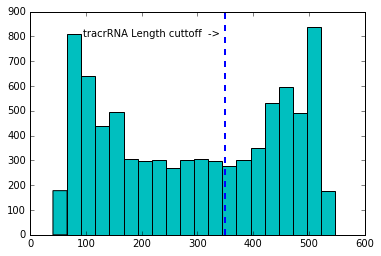

count    8201.000000
mean      295.160224
std       156.122720
min        41.000000
25%       141.000000
50%       300.000000
75%       448.000000
max       547.000000
dtype: float64


In [8]:
from pandas import Series
from matplotlib import pyplot as plt
ser = Series(sizeDist)
plt.hist(ser,bins=20, color='c')
plt.axvline(350, color='b', linestyle='dashed', linewidth=2)
plt.text(95,800,'tracrRNA Length cuttoff  ->')
plt.show()
print ser.describe()

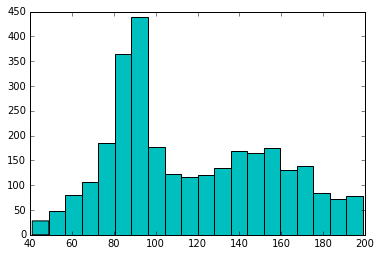

count    2938.000000
mean      116.797481
std        38.029684
min        41.000000
25%        87.000000
50%       107.000000
75%       148.000000
max       199.000000
dtype: float64


In [9]:
ser = ser[ser<200]
plt.hist(ser,bins=20, color='c')
plt.title = "Possible tracrRNA length distribution"
plt.show()
print ser.describe()

count    1454.00000
mean       69.14099
std         6.97326
min        41.00000
25%        66.00000
50%        66.00000
75%        73.00000
max       104.00000
dtype: float64


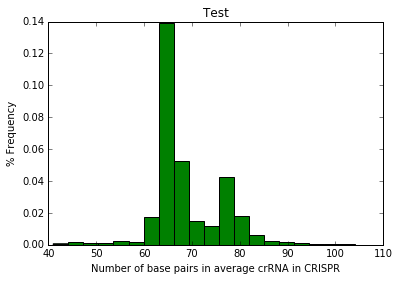

In [10]:
ser = Series(crRNALens)
ser = ser [ser > 40]
ax = ser.plot.hist(bins=20,title="Test",normed=True,color='g',edgecolor="k") #,grid=True)
ax.set_xlabel("Number of base pairs in average crRNA in CRISPR")
ax.set_ylabel("% Frequency")
ax
print ser.describe()

In [11]:
%%bash
cd-hit-est -i sequences/AllPredictedTracrRNAs.fa -o clusters/AllPredictedTracrRNAs.grouped.fa -M 0 -d 0 -c .90 -T 0

Program: CD-HIT, V4.7 (+OpenMP), Jul 11 2017, 18:04:58
Command: cd-hit-est -i sequences/AllPredictedTracrRNAs.fa -o
         clusters/AllPredictedTracrRNAs.grouped.fa -M 0 -d 0 -c
         .90 -T 0

Started: Wed Dec 12 19:24:16 2018
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 20
Actual number of CPUs to be used: 20

total seq: 4477
longest and shortest : 352 and 41
Total letters: 778696
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 1M
Buffer          : 20 X 12M = 243M
Table           : 2 X 16M = 33M
Miscellaneous   : 4M
Total           : 282M

Table limit with the given memory limit:
Max number of representatives: 547213
Max number of word counting entries: 22049424

# comparing sequences from          0  to        203
---------- new table with      168 representatives
# comparing sequences from        203  to        397
--

In [3]:
clusterID = ""
allClusters, allClusterSeqIDs = {},{}
# print tracrSeqDict.keys()
for line in open("clusters/AllPredictedTracrRNAs.grouped.fa.clstr"):
    if ">Cluster" in line:
        clusterID = line.strip().replace(">","")
    else:
        sequenceID = line[line.find(">")+1:line.find(".")] 
        seqID = line[line.find(">")+1:line.find("...")] 
        seqID = seqID[:seqID.rfind("_")]
        try:allClusters[clusterID].add(seqID)
        except:allClusters[clusterID]=set([seqID])
        try:allClusterSeqIDs[seqID].add(clusterID)
        except:allClusterSeqIDs[seqID]=set([clusterID])


xs,ys,zs=[],[],[]
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

#for i in range(2,50):
remove=set()
colors,TreeColors={},{}
clusterDist=[]
for cluster, ids in allClusters.iteritems():
    clusterDist.append(len(ids))
    if len(ids) < 2: remove.add(cluster)
    else:
        colors[cluster]=color()
        for id in ids:TreeColors[id.replace(".","_")] = colors[cluster]
for id in remove: del allClusters[id]

print "\tTotal number of clusters:",len(allClusters)
print "\tNumber of nodes covered:",len(TreeColors)

# xs.append(len(allClusters))
# ys.append(len(TreeColors))
# zs.append(i)
# ax.scatter(ys,xs,zs)    
# # xs.reverse()
# # ys.reverse()
# # plt.plot(xs, ys, 'ro')
# plt.show()

	Total number of clusters: 254
	Number of nodes covered: 532


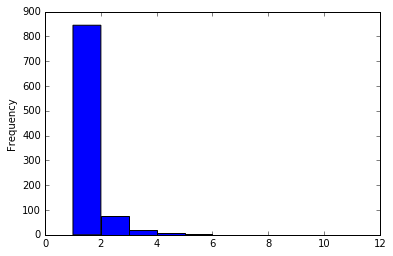

In [14]:
clusterDist = Series(clusterDist)
clusterDist.plot.hist();

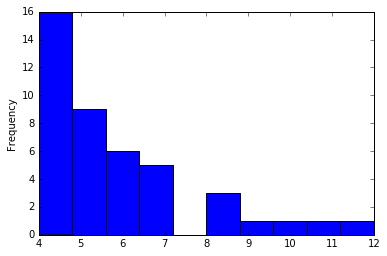

In [15]:
dist=[]
for cluster, ids in allClusterSeqIDs.iteritems():
    id_len = len(ids)
    if id_len > 3: dist.append(id_len)
dist = Series(dist)
dist.plot.hist();

In [5]:
tmpDict = {}
clusterCount = 0
tracrSeqDict = fasta_index("sequences/AllPredictedTracrRNAs.fa","fasta")
for id,seq in tracrSeqDict.iteritems(): tmpDict[id[:id.rfind("_")]]=str(seq.seq).upper()
tracrSeqDict = tmpDict  
for cluster, seqIDList in allClusters.iteritems():
    clusterFileName = "conseqs2/"+cluster.replace(" ","_")+".fasta"
    fh = open(clusterFileName,"wb")
    clusterStats = []
    for seqID in seqIDList: clusterStats.append(len(tracrSeqDict[seqID]))
    clusterStats = Series(clusterStats)
    keepSeqs = clusterStats[~((clusterStats-clusterStats.mean()).abs() > clusterStats.std())]
    minSeq, maxSeq = keepSeqs.min(), keepSeqs.max()
    index=0
    for seqID in seqIDList: 
        seqLen = len(tracrSeqDict[seqID])
        if seqLen >= minSeq and seqLen <= maxSeq:
            index+=1
            fh.write(">%s\n%s\n" % (seqID,tracrSeqDict[seqID]))
    fh.close()
    if index <= 1:
        os.system("rm %s" % (clusterFileName))
        continue
    print clusterFileName,"(",index,"/",len(seqIDList), ")[%i,%i]" % (minSeq,maxSeq),clusterStats.std() 
    os.system("cd-hit-est -i %s -o %s_cluster -M 0 -d 0 -c .90 -T 0 -sc 1" % (clusterFileName,clusterFileName))
    clusteredResults = processClusterFile("%s_cluster.clstr" % (clusterFileName))
    fh = open(clusterFileName,"wb")
    index = 0 
    for seqID,direction in clusteredResults.filter():
        index +=1
        if direction: fh.write(">%s\n%s\n" % (seqID,str(tracrSeqDict[seqID])))
        else: fh.write(">%s\n%s\n" % (seqID, reverse_complement(tracrSeqDict[seqID])))
    fh.close()
    if index <= 1:
        os.system("rm %s" % (clusterFileName))
        clusterCount -= 1
    os.system("rm %s_cluster*" % (clusterFileName))
    clusterCount+=1

conseqs2/Cluster_1033.fasta ( 2 / 2 )[98,163] 45.9619407771


In [16]:
%%bash
for i in 1 2 3 4 5 6 7 8 9 10
do
    sbatch ../scripts/hpc/StructureSearch.sb
done

Submitted batch job 3723240
Submitted batch job 3723241
Submitted batch job 3723243
Submitted batch job 3723244
Submitted batch job 3723245
Submitted batch job 3723246
Submitted batch job 3723247
Submitted batch job 3723248
Submitted batch job 3723249
Submitted batch job 3723250


# Process the infernal results

In [6]:
infernalResults = ProcessInfernal(2)

Dumping /mnt/research/germs/shane/transActRNA/data/pickles/InfernalResults02.p Number of results: 1119


# Build a structural results tree uisng a combination of the previous and current search results

<h4>Build color mappers and counters and separate into groups</h4>

In [7]:
knownTracrRNAs = load(open("pickles/KnownTracrStuctureHitColors.p","rb"))
knownTracrIDColorMap, knownTracrColorCounter = {}, {}
for id,color in knownTracrRNAs.iteritems():
    try:knownTracrIDColorMap[color].add(id)
    except:knownTracrIDColorMap[color]=set([id])
    try:knownTracrColorCounter[color]+=1
    except:knownTracrColorCounter[color]=1
knownTracrColorCounter = Counter(knownTracrColorCounter)
unknownClusterCounter = {}
for struct,ids in infernalResults.structMapping.iteritems(): unknownClusterCounter[struct] = len(ids)

#Tell us about what we are annotating
unknownTracrRNAs = set(casRelatedAssemblies.keys()).difference(knownTracrRNAs)        
print "Known:%i/%i\nUnknown:%i/%i\n\tClusters:%i\n" % (len(knownTracrRNAs),len(casRelatedAssemblies),len(unknownTracrRNAs),len(casRelatedAssemblies),len(knownTracrColorCounter)) 

newTracrRNAs = set(unknownTracrRNAs).intersection(infernalResults)
allFound = set(knownTracrRNAs.keys()).union(infernalResults)
stillMissing = set(casRelatedAssemblies.keys()).difference(allFound)
print "Found: %i/%i\nRemaining: (%i/%i or %i/%i)\n\tClusters: %i" % (len(newTracrRNAs),len(unknownTracrRNAs),len(stillMissing),len(unknownTracrRNAs),len(stillMissing),len(casRelatedAssemblies),len(unknownClusterCounter))

print "TracrRNAs:\n\t%i/%i Found\n\tClusters: %i or less because predicted may not have been picked up in previous search" % (len(knownTracrRNAs)+len(newTracrRNAs),len(casRelatedAssemblies),len(unknownClusterCounter))

Known:991/1458
Unknown:467/1458
	Clusters:46

Found: 207/467
Remaining: (260/467 or 260/1458)
	Clusters: 229
TracrRNAs:
	1198/1458 Found
	Clusters: 229 or less because predicted may not have been picked up in previous search


<h4>Divide the groups into their new/shared colors</h4>

In [8]:
def findBiggestCluster(clusters, clusterMap): return Counter(dict((k, clusterMap[k]) for k in (clusters))).most_common(1)[0][0] 

newColors,newColorMap, TreeColors,newIDs = {}, {}, knownTracrRNAs.copy(), set()
startLen = len(TreeColors)
print "Started with %i tracrRNAs" % (startLen)
for seqID in newTracrRNAs:
#     print "Next",seqID
    #Get all the clusters the ID is associated with:
    clusters = infernalResults[seqID]
    
    #Get all of the IDs associated with those clusters
    clusterIDS = set()
    for cluster in clusters: clusterIDS = clusterIDS.union(infernalResults[cluster])
        
    #Check to see if there is overlap betweeb the IDs of the known and the IDs of the predicted for this new tracr
    overlappingIDs = clusterIDS.intersection(knownTracrRNAs)
    
    if len(overlappingIDs)>0:#If there is overlap
        #Get the cluster color(s) of the overlapping IDs
        colors = set()
        for o_id in overlappingIDs: colors.add(knownTracrRNAs[o_id])
            
        #Choose the biggest color
        id_color = findBiggestCluster(colors,knownTracrColorCounter)

    else: #No overlap, choose the best color from new clusters
        biggestCluster = findBiggestCluster(clusters,unknownClusterCounter)
        try: id_color = newColors[biggestCluster]; newColorMap[newColors[biggestCluster]].add(seqID)
        except: id_color = newColors[biggestCluster] = genColor(); newColorMap[newColors[biggestCluster]] = set([seqID])
        newIDs.add(seqID)
    TreeColors[seqID] = id_color

print "Annotated %i/%i" % (len(TreeColors),len(casRelatedAssemblies))
print "\t",len(TreeColors)-startLen, "found"
print "\t",len(newIDs), "/", len(TreeColors)-startLen, "contain a unique structure"
print "\t",len(newColors), "/", len(newColors)+len(knownTracrColorCounter), "new clusters"

dump(TreeColors, "pickles/AllPredictedTracrRNA_colors.p")

Started with 991 tracrRNAs
Annotated 1198/1458
	207 found
	64 / 207 contain a unique structure
	14 / 60 new clusters

Dumping pickles/AllPredictedTracrRNA_colors.p


# Stats on what was found

Total of 14 novel tracrRNA clusters
Containing 64 tracrRNAs


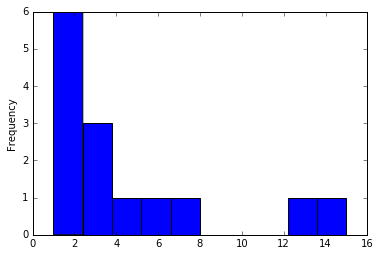

In [9]:
dist = []
for ids in newColorMap.values(): dist.append(len(ids))
dist = Series(dist)
#print dist.describe()
dist.plot.hist();  
print "Total of %i novel tracrRNA clusters" % (len(newColorMap))
print "Containing %i tracrRNAs" % (dist.sum())

# Visually inspect what results are new and especially those in new clusters

In [26]:
TreeColors = pickle.load(open("pickles/PaperCombinedTreeColors.p"))
knownBoth, structOnly, blastOnly= set(),set(),set()
for id,color in TreeColors.iteritems():
    if   color == "#70857A": knownBoth.add(id)
    elif color == "#F4B266": structOnly.add(id)
    elif color == "#9B7E46": blastOnly.add(id)
print len(knownBoth), len(structOnly), len(blastOnly),"\n"

print len(knownBoth.intersection(newIDs))
print len(structOnly.intersection(newIDs))
print len(blastOnly.intersection(newIDs)), "That's interesting"

for id in newTracrRNAs: TreeColors[id] = "#0099ff"
dump(TreeColors,"pickles/PredictedTracrRNA_colors_bySearchMethod.p")

667 324 30 

0
0
4 That's interesting

Dumping pickles/PredictedTracrRNA_colors_bySearchMethod.p


# Programming Artifacts Below

In [4]:
import itertools
for cluster, ids in allClusters.iteritems():
    if len(ids)<=3:continue
    maxOverlap = 0
    for seq1, seq2 in itertools.combinations(ids, 2):
        maxOverlap = max(len(allClusterSeqIDs[seq1].intersection(allClusterSeqIDs[seq2])),maxOverlap)
    print cluster, "%i/%i" % (maxOverlap, len(ids))

NameError: name 'allClusters' is not defined

In [13]:
for cluster, ids in allClusterSeqIDs.iteritems():
    print cluster
    num=0
    for id in ids:
        num+=1
        print "\t%i. %s" % (num,id)

Cluster 936
	1. NZ_FYDB01000008.1_ORF1
	2. NZ_JRWE01000053.1_ORF1
	3. PABT01000022_ORF1
Cluster 803
	1. NZ_BEWZ01000027.1_ORF1
	2. NZ_PKID01000005.1_ORF1
	3. NZ_PNGD01000017.1_ORF1
	4. NZ_NCVG01000019.1_ORF2
Cluster 799
	1. NZ_AUKZ01000017.1_ORF1
	2. NZ_JPFU01000002.1_ORF1
	3. NZ_GL732492.1_ORF1
Cluster 483
	1. NZ_AJKQ01000017.1_ORF1
	2. NZ_JVWP01000001.1_ORF1
	3. NZ_GL732470.1_ORF1
	4. NZ_NCUH01000007.1_ORF1
	5. NZ_NCUF01000007.1_ORF1
	6. NZ_NCUC01000010.1_ORF1
	7. NZ_KV832087.1_ORF1
	8. NZ_NCUE01000015.1_ORF1
	9. NZ_JYGU01000007.1_ORF1
	10. NZ_ALJN01000008.1_ORF1
	11. NZ_NCUP01000005.1_ORF2
	12. NZ_LNVH01000012.1_ORF1
	13. NZ_LVJM01000010.1_ORF1
	14. NZ_PKIF01000003.1_ORF1
Cluster 664
	1. BBPW01000006_ORF1
	2. NZ_AJGU01000019.1_ORF1
	3. DGUJ01000289_ORF1
	4. LVBI01000042_ORF2
Cluster 1435
	1. NZ_JRJB01000004.1_ORF1
	2. NZ_KQ033871.1_ORF2
	3. NZ_KQ034019.1_ORF1
Cluster 256
	1. AFFO01000009_ORF1
	2. NZ_JYGN01000007.1_ORF2
	3. NZ_LAWN01000002.1_ORF1
	4. NZ_KQ969342.1_ORF1
	5. NZ_LAWJ010

In [4]:
from Bio.SeqIO import parse, write
casRelatedAssemblies = {}
for id in allCas9s:
    seqID = id[:id.rfind("_")]
    for rec in parse("assemblies/%s.fasta" % id,"fasta"):
        if rec.id == seqID:
#             with open("assemblies/%s.fa" % id, "wb") as fh:
#                 write([rec],fh,"fasta") 
            casRelatedAssemblies[id]=str(rec.seq)
            break

In [5]:
fh = open("casRelatedAssemblies.fasta","wb")
for id,seq in casRelatedAssemblies.iteritems(): fh.write(">%s\n%s\n" % (id,seq))
fh.close()

In [ ]:
numPos
numTerminators
tracrSeqDict

In [17]:
newSolutions

{}

In [14]:
%%bash
mkdir tmp
ls -l 

total 95538
drwx--s--x 2 dooleys1 germs     2672 Jun 27 15:34 assemblies
-rw-r--r-- 1 dooleys1 germs  3388226 Jul  6 17:13 Cas9-Like-clustered.faa
-rw-r--r-- 1 dooleys1 germs   611108 Jul  6 17:13 Cas9-Like-clustered.faa.clstr
-rw-r--r-- 1 dooleys1 germs 17415584 Jul  6 17:13 Cas9-Like.faa
-rw-r--r-- 1 dooleys1 germs        0 Jul  6 18:06 Crispr_results_2018.tsv
drwx--s--x 2 dooleys1 germs     5342 Jul  6 20:37 crisprs
drwx--s--x 2 dooleys1 germs        3 Jun 27 17:17 crisprs2
drwx--s--x 7 dooleys1 germs       12 Jul  6 17:03 diverseCas9s
-rw-r--r-- 1 dooleys1 germs   379734 Jul  6 16:44 DiverseCas9s.aln
-rw-r--r-- 1 dooleys1 germs   122512 Jul  6 16:25 DiverseCas9s.faa
-rw------- 1 dooleys1 germs    18339 Jul  6 16:44 DiverseCas9s.faa.tree
-rw-r--r-- 1 dooleys1 germs   480438 Jul  6 16:44 DiverseCas9s.hmm
drwx--s--x 2 dooleys1 germs       22 Jun 29 15:38 domains
drwx--s--x 3 dooleys1 germs   222460 Jun  6 13:38 hmmSearch
drwx--s--x 2 dooleys1 germs      113 Jul  6 18:01 logs
drwxr-sr-

In [ ]:
################### ARTIFACTS BELOW ###########################
clusterSizes = []
index = 0
colors = {
    0:"#C0C0C0", 1:"#808080",
    2:"#FF0000", 3:"#800000",
    4:"#FFFF00", 5:"#808000",
    6:"#00FF00", 7:"#008000",
    8:"#00FFFF", 9:"#008080",
    10:"#0000FF", 11:"#000080",
    12:"#FF00FF", 13:"#800080",
    14:"#DAF7A6", 15:"#FF5733",
    16:"#C70039", 17:"#900C3F",
    18:"#900C3F", 19:"#900C3F",
    20:"#900C3F", 21:"#900C3F",
    22:"#900C3F", 23:"#900C3F",
    24:"#900C3F", 25:"#900C3F",
    26:"#900C3F", 27:"#900C3F"
}
# for cluster in allClusters: 
#     clusterSizes.append(len(allClusterSeqIDs[cluster]))
#     if len(allClusterSeqIDs[cluster])>=3: 
#         fh = open("data/%s.fa" %(cluster.replace(" ","_")),"w")
#         for id in allClusters[cluster]: 
#             fh.write(">%s\n%s\n" % (id,tracrSeqDict[id]))
#             #TreeColors[id[:id.find("_")]] = colors[index]
#             print id[:id.find("_")],
#         print
#         index += 1
#         fh.close()
#     print "data/%s.fa" % (cluster.replace(" ","_"))
# print "# indices needed:", index-1
# ser = Series(clusterSizes)
# ser.plot.hist()
# print ser.describe() 

In [11]:
files = os.listdir("./")
for fn in files:
    baseid = fn[:fn.find("_ORF")]+"_orfs.blastout"
    #os.system("mv %s %s" % (fn,baseid))
    

In [6]:
%%bash
ls


1334.41.con.0015_ORF1.fa_orfs.faa.blastout
1349.117.con.0062_ORF1.fa_orfs.faa.blastout
1349.140.con.0070_ORF1.fa_orfs.faa.blastout
1349.210.con.0040_ORF1.fa_orfs.faa.blastout
1349.218.con.0024_ORF1.fa_orfs.faa.blastout
1349.230.con.0005_ORF1.fa_orfs.faa.blastout
1733.120.con.0044_ORF1.fa_orfs.faa.blastout
1733.647.con.0010_ORF1.fa_orfs.faa.blastout
1765.172.con.18_ORF2.fa_orfs.faa.blastout
ADGF01000040_ORF1.fa_orfs.faa.blastout
AEQQ01000063_ORF1.fa_orfs.faa.blastout
AEUY01000011_ORF1.fa_orfs.faa.blastout
AFFO01000009_ORF1.fa_orfs.faa.blastout
AGAZ01000013_ORF1.fa_orfs.faa.blastout
AGDR01000026_ORF1.fa_orfs.faa.blastout
AGDW01000008_ORF1.fa_orfs.faa.blastout
AGDY01000007_ORF1.fa_orfs.faa.blastout
AGEF01000010_ORF1.fa_orfs.faa.blastout
AGEI01000029_ORF1.fa_orfs.faa.blastout
AGSA01000024_ORF1.fa_orfs.faa.blastout
AGXX01000004_ORF1.fa_orfs.faa.blastout
AHAD01000002_ORF1.fa_orfs.faa.blastout
AHIT01000017_ORF1.fa_orfs.faa.blastout
AHKQ01000003_ORF1.fa_orfs.faa.blastout
AJAN01000025_ORF1.fa_o

In [ ]:
################################ Custom Functions ################################
from Bio.SubsMat import MatrixInfo as matlist
matrix = matlist.blosum62
gap_open = -8
gap_extend = -.8

def RC(seq): return str(Seq(seq).reverse_complement())
def scoreAlign(alignment):
    ref, frag, score, begin, end = alignment
    matches = 0
    for pos in range(len(ref)):
        if ref[pos] == frag[pos]:matches+=1
    return matches/float(len(frag.replace("-","")))         
def scoreAligns(aln1,aln2):
    score1, score2 = scoreAlign(aln1), scoreAlign(aln2)
    if score1 > score2: return aln1,score1*100
    else: return aln2, score2*100   
    
def alignSequences(refSeq,fragment):
    try: aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    except: aln1 = None
    try: aln2 = pairwise2.align.globalds(refSeq, RC(fragment), matrix, gap_open, gap_extend)[0]
    except: aln2 = None
    if aln1 == None and aln2 == None: return None,0
    elif aln1 == None: top_aln = aln2
    elif aln2 == None: top_aln = aln1
    else: top_aln,alnScore = scoreAligns(aln1,aln2)
    if alnScore == None: alnScore = 0    
    if top_aln == None:print "Here"
    aln_probe, aln_arms, score, begin, end = top_aln
    return alnScore

def alignSequence(refSeq,fragment):
    aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    try: aln1 = pairwise2.align.globalds(refSeq, fragment, matrix, gap_open, gap_extend)[0]
    except: aln1 = None
    try: aln2 = pairwise2.align.globalds(refSeq, RC(fragment), matrix, gap_open, gap_extend)[0]
    except: aln2 = None
    if aln1 == None and aln2 == None: return None,0
    elif aln1 == None: top_aln = aln2
    elif aln2 == None: top_aln = aln1
    else: top_aln,alnScore = scoreAligns(aln1,aln2)
    if alnScore == None: alnScore = 0    
    if top_aln == None:print "Here"
    aln_probe, aln_arms, score, begin, end = top_aln
    return '%s\t%% Matching %.2f%%\n\t%s' % (aln_probe, alnScore, aln_arms), alnScore